In [117]:
%pip install boto3 matplotlib pandas -q


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


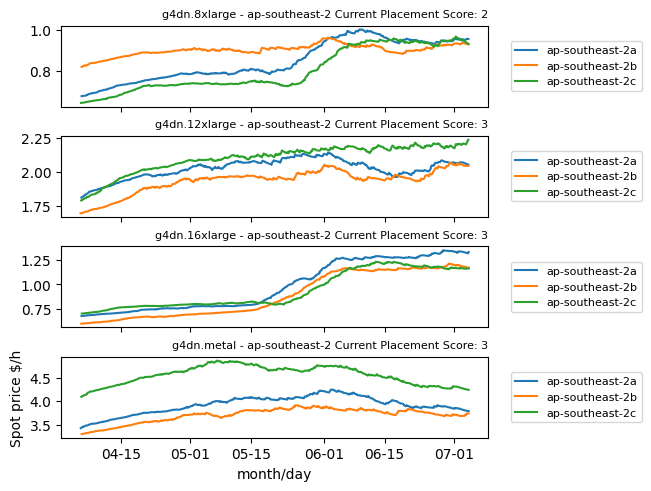

In [118]:
import boto3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

client = boto3.client('ec2', region_name="ap-southeast-2")

end = datetime.datetime.now()
start = end - datetime.timedelta(days=90)

InstanceTypes = [
    'g4dn.8xlarge',
    'g4dn.12xlarge',
    'g4dn.16xlarge',
    'g4dn.metal',
]

data = (client
    .get_paginator('describe_spot_price_history')
    .paginate(EndTime=end,InstanceTypes=InstanceTypes,ProductDescriptions=['Linux/UNIX'],StartTime=start)
    .build_full_result()
)

df = pd.DataFrame(data['SpotPriceHistory'])
df = df.set_index(['Timestamp'])

df.SpotPrice=pd.to_numeric(df.SpotPrice)

pt = []
for t in InstanceTypes:
    # get the spot placement scores - can be removed 
    score = client.get_spot_placement_scores(InstanceTypes=[t], TargetCapacity=20,RegionNames=["ap-southeast-2"])    
    pt.append([t,
               df.loc[df['InstanceType'] == t].pivot_table(index=['Timestamp'], columns=['AvailabilityZone'], values='SpotPrice'),
                f"{score['SpotPlacementScores'][0]['Region']} Current Placement Score: {score['SpotPlacementScores'][0]['Score']}"
              ])

fig,ax = plt.subplots(nrows=len(pt), layout='constrained', sharex=True)

for i, p in enumerate(pt):
    plotdf = p[1].interpolate()
    for az in plotdf:
        ax[i].plot(plotdf.index,plotdf[az], label=az)
    ax[i].legend(bbox_to_anchor=(1.04, 0.5), loc="center left",fontsize=8)
    ax[i].set_title(f"{p[0]} - {p[2]}", loc="right", fontsize=8)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.xlabel('month/day')
plt.ylabel('Spot price $/h', loc="center")
plt.show()